In [1]:
import numpy as np 
import glob 
import vtk
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from AngioMorphPCA.preprocessing import parameterize_curve, calculate_3d_curve_abscissas,remove_high_freq_components, min_max_normalize, autocovariance_function
from AngioMorphPCA.io import Get_simple_vtk, makeVtkFile
from scipy.integrate import simps
from AngioMorphPCA.GenerateDiffHemeo import generate_diff_homeomorphism
from AngioMorphPCA.srvf_rep import compute_srvf_func, reconstruct_curve_from_srvf
from AngioMorphPCA.L2distance import calculate_l2_distance
from AngioMorphPCA.compute_geometry import compute_curvature_and_torsion,build_curve_from_curvatures
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings



# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def calculate_curve_length(curve):
    """
    计算形状为 (n, 3) 的 3D 曲线的总长度。
    
    参数:
        curve (numpy.ndarray): 形状为 (n, 3) 的 3D 曲线，包含 n 个点的坐标 (x, y, z)。
    
    返回:
        float: 曲线的总长度。
    """
    # 计算相邻点之间的差值
    diffs = np.diff(curve, axis=0)
    
    # 计算每个差值的欧氏距离，并求和
    segment_lengths = np.sqrt((diffs ** 2).sum(axis=1))
    total_length = segment_lengths.sum()
    
    return total_length

def calculate_abscissas(curve):
    """
    计算形状为 (n, 3) 的 3D 曲线每个点的累计弧长（abscissas）。
    
    参数:
        curve (numpy.ndarray): 形状为 (n, 3) 的 3D 曲线，包含 n 个点的坐标 (x, y, z)。
    
    返回:
        numpy.ndarray: 一个形状为 (n,) 的数组，包含每个点对应的累计弧长。
    """
    # 计算相邻点之间的差值
    diffs = np.diff(curve, axis=0)
    
    # 计算每个相邻点对之间的距离
    segment_lengths = np.sqrt((diffs ** 2).sum(axis=1))
    
    # 计算累计弧长，起始点的弧长为 0
    abscissas = np.concatenate(([0], np.cumsum(segment_lengths)))
    
    return abscissas

curve_bs = np.load("../geom_aligned_curves_abj/geomstats_aligned_to_first_bravawithj.npy")[:-4]
curve_cs = np.load("../geom_aligned_curves_abj/geomstats_aligned_to_first_bravawithj.npy")[:-4]
# unaligned_curvatures = np.load("../unaligned_curvatures.npy")
files = np.load("../geom_aligned_curves_abj/total_files.npy")[:curve_bs.shape[0]]

print ("curve_bs.shape:", curve_bs.shape)
# print (unaligned_curvatures.shape)
print ("files length:", files.shape[0])

brava_num = len(curve_bs)
k_sampling_points = 120

original_centerlines = []
abscissas = []
for i in range(len(files)):
    # print ("files[i]:", files[i])
    original_centerline = Get_simple_vtk("../"+files[i])
    # print ("original_centerline.shape:", original_centerline.shape)
    print (calculate_curve_length(original_centerline), calculate_curve_length(curve_bs[i]))
    original_centerlines.append(original_centerline)
    abscissas.append(calculate_abscissas(original_centerline))



original_centerlines = np.array(original_centerlines)
abscissas = np.array(abscissas)


curve_bs.shape: (79, 119, 3)
files length: 79
79.2532107896111 0.988287373259153
71.2856941716775 0.9807732379385738
81.99732061168635 0.9883072440705669
76.84593306337732 0.9868162645256428
84.42219706515498 0.98728184249317
82.51976985095165 0.9874980434120821
68.148084887353 0.9852561575309309
70.29056645709093 0.9867023434656611
62.64020846369101 0.9874736579534866
59.226106217694706 0.990212729475038
81.17170446694841 0.9872954676811688
72.55681136334347 0.9876538721878394
89.5732780821605 0.987967355093051
72.3216727210226 0.9862185350595626
93.31776822887464 0.98190259088653
90.63102213378802 0.981658770164441
68.49260917930133 0.9876193281470651
66.34326470721825 0.9865057656498606
78.0194813057584 0.9863008901413709
73.91862181493943 0.9810763130911232
80.31522199885775 0.979804324202744
80.39740696301176 0.9884739929810482
72.8872951189621 0.9846798402005845
72.45990096976132 0.9840407146592253
87.92834101687788 0.9860006746742415
84.83146452428466 0.9839835354707243
77.23885

In [2]:
import matplotlib.pyplot as plt
from geomstats.learning.frechet_mean import FrechetMean
import geomstats.backend as gs
from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    SRVMetric,
    insert_zeros,
)
from geomstats.learning.pca import TangentPCA
import seaborn as sns

k_sampling_points = 120

curves_r3 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3, k_sampling_points=k_sampling_points, equip=True
)

curves_r3.equip_with_metric(SRVMetric)

mean = FrechetMean(curves_r3)
mean.fit(curve_cs)

mean_estimate = mean.estimate_
tangent_base = mean.estimate_


INFO: Using numpy backend
INFO: Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: NumExpr defaulting to 8 threads.


d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:38: RuntimeWarning: invalid value encountered in divide
  curvature = np.where(r_prime_norm**3 > epsilon, cross_norm / (r_prime_norm ** 3), 0)
d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:41: RuntimeWarning: invalid value encountered in divide
  torsion = np.where(cross_norm**2 > epsilon, torsion_numerator / (cross_norm ** 2), 0)


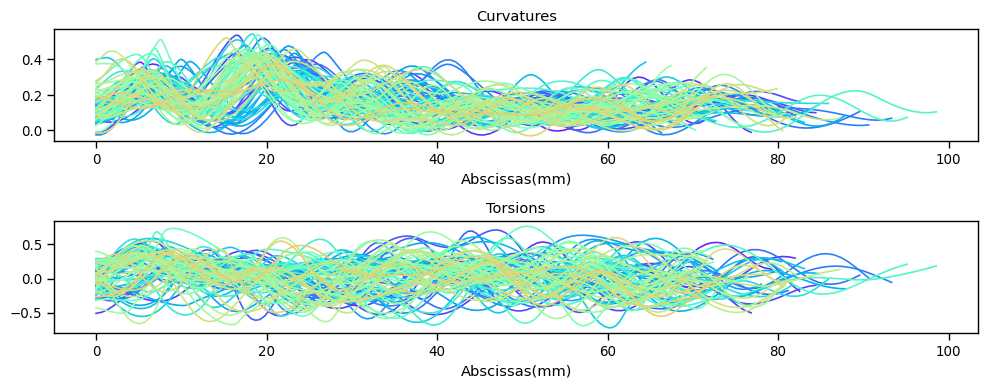

In [3]:
import matplotlib.cm as cm

def set_x_ticks_normalized(ax,x_array,num=5):
    ax.set_xlim(0, len(x_array) - 1)
    ax.set_xticks(np.linspace(0, len(x_array)-1, num=num))
    ax.set_xticklabels(['{:.2f}'.format(x) for x in np.linspace(0, 1, num=num)])
    ax.autoscale(enable=True, axis='x', tight=True)


curvatures = []
torsions = []

for i in range(len(curve_cs)):
    c,t = compute_curvature_and_torsion(original_centerlines[i])
    fft_c = remove_high_freq_components(c,0.05)
    fft_t = remove_high_freq_components(t,0.05)
    curvatures.append(fft_c)
    torsions.append(fft_t)
curvatures = np.array(curvatures)
torsions = np.array(torsions)

# 假设 curve_cs、abscissas、curvatures、torsions 已定义
# 使用 viridis 调色板
num_curves = len(curve_cs)
# colors = cm.hsv(np.linspace(0, 1, num_curves))  # 为每条曲线生成一个颜色
colors = cm.rainbow(np.linspace(0.05, 0.70, num_curves))
sns.set_context("paper", font_scale=1.1)
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for i in range(num_curves):
    ax1.plot(abscissas[i], curvatures[i], color=colors[i], label='curve {}'.format(i))
    ax2.plot(abscissas[i], torsions[i], color=colors[i], label='curve {}'.format(i))

ax1.set_title('Curvatures')
ax2.set_title('Torsions')
ax1.set_xlabel('Abscissas(mm)')
ax2.set_xlabel('Abscissas(mm)')


plt.tight_layout()
plt.show()

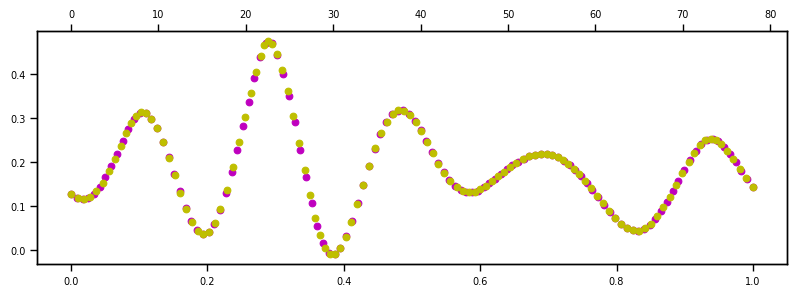

In [4]:
import numpy as np
from scipy.interpolate import interp1d

def parameterize_1d_curve(curve, abscissas):
    """
    Create a function to parameterize a 1D curve with non-uniform abscissas.
    
    :param curve: A 1D numpy array representing the curve's discrete y-values.
    :param abscissas: A 1D numpy array representing the x-values (abscissas) of the curve, should be the same length as `curve`.
    :return: A function that takes a vector of parameter values (t) and returns interpolated points on the curve.
    """
    # Normalize abscissas to the range [0, 1] for consistent parameterization
    t_values = (abscissas - abscissas.min()) / (abscissas.max() - abscissas.min())

    # Create an interpolation function for the curve
    interpolate_y = interp1d(t_values, curve, kind='cubic', fill_value="extrapolate")

    def curve_function(t_vector):
        # Clamp t_vector values to be within [0, 1]
        t_vector_clamped = np.clip(t_vector, 0, 1)
        
        # Interpolate y-values at the given t values
        y = interpolate_y(t_vector_clamped)
        return y

    return curve_function


reparam_curvatures = []
# 计算参数 t 在 [0, 1] 内的几个点上的插值值
t_vector = np.linspace(0, 1, curvatures.shape[1])
for i in range(len(files)):
    curve_func = parameterize_1d_curve(curvatures[i], abscissas[i])
    interpolated_points = curve_func(t_vector)
    reparam_curvatures.append(interpolated_points)

reparam_curvatures = np.array(reparam_curvatures)

i=18
sns.set_context("paper", font_scale=0.8)
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)
ax.scatter(t_vector, reparam_curvatures[i], color='m',label='Interpolated Curve')
ax2 = ax.twiny()
ax2.scatter(abscissas[i], curvatures[i], color='y', label='Original Curve Points')
# ax.legend()
# ax.set_title('Interpolated Curve vs. Original Points')
plt.tight_layout()
plt.show()

In [5]:
# !pip install scikit-fda
from skfda.datasets import fetch_growth, make_multimodal_samples
from skfda.exploratory.stats import fisher_rao_karcher_mean
from skfda.preprocessing.registration import FisherRaoElasticRegistration
from skfda import FDataGrid

# curvatures = curve_bs[:,:,2]

# n, k = curvatures.shape
# print (n, k)
# x_grid = np.linspace(0, 1, k)
x_grid = t_vector.copy()

fd = FDataGrid(data_matrix=reparam_curvatures, grid_points=x_grid)

# 创建 FisherRaoElasticRegistration 对象
elastic_registration = FisherRaoElasticRegistration()

# 执行曲线对齐
fd_aligned = elastic_registration.fit_transform(fd)

# 计算对齐后的均值曲线 (Karcher Mean)
mean_function = fisher_rao_karcher_mean(fd_aligned).data_matrix[0,:,0]
print ("mean_function.shape:", mean_function.shape)


# 将对齐后的曲线数据提取为 numpy array
aligned_curvatures = fd_aligned.data_matrix[:,:,0]
print ("aligned_curves.shape:", aligned_curvatures.shape)

# 提取变形函数
warping_functions = elastic_registration.warping_.data_matrix[:,:,0]
print ("warping_functions.shape:", warping_functions.shape)

mean_function.shape: (120,)
aligned_curves.shape: (79, 120)
warping_functions.shape: (79, 120)


Peak values: [0.27995268 0.39757882 0.23596504 0.17511512 0.21747584]
Peak indices: [  9  32  51  73 110]
Trough values: [0.10123544 0.1232461  0.07098966 0.04983008]
Trough indices: [19 44 63 86]


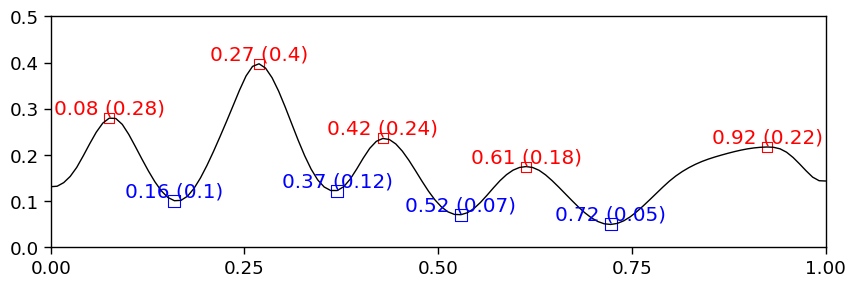

In [6]:
import numpy as np
from scipy.signal import find_peaks
import seaborn as sns
# 假设 mean_function 已定义并为 1D numpy array
# mean_function = fisher_rao_karcher_mean(fd_aligned).data_matrix[0,:,0]

# 找到峰值的位置和对应的值
peak_indices, _ = find_peaks(mean_function)
peaks = mean_function[peak_indices]

# 找到谷值的位置和对应的值
trough_indices, _ = find_peaks(-mean_function)
troughs = mean_function[trough_indices]

# 输出峰值和谷值
print("Peak values:", peaks)
print("Peak indices:", peak_indices)
print("Trough values:", troughs)
print("Trough indices:", trough_indices)

sns.set_context("paper", font_scale=1.5)
fig = plt.figure(figsize=(10, 3),dpi=100)
ax = fig.add_subplot(111)
ax.plot(mean_function,  alpha=1, linewidth=1, color="k")

for i in range(len(peaks)):
    ax.text(peak_indices[i], peaks[i], "{} ({})".format(round(peak_indices[i]/len(mean_function),2), round(peaks[i],2)), color='r',ha='center',va='bottom')
for i in range(len(troughs)):
    ax.text(trough_indices[i], troughs[i], "{} ({})".format(round(trough_indices[i]/len(mean_function),2), round(troughs[i],2)), color='b',ha='center',va='bottom')
ax.scatter(peak_indices, peaks, color='white',edgecolors='r', s=50, label='Peaks',marker='s')
ax.scatter(trough_indices, troughs, color='white',edgecolors='b', s=80, label='Troughs',marker='s')
ax.set_ylim(0, 0.5)
set_x_ticks_normalized(ax,curvatures[0])

In [7]:
files_label = []
for i in range(len(files)):
    files_label.append("_".join([files[i].split('\\')[-1].split('.')[0].split('_')[0],files[i].split('\\')[-1].split('.')[0].split('_')[-1]]))

print (files_label)

['BG0001_L', 'BG0001_R', 'BG0004_L', 'BG0004_R', 'BG0006_L', 'BG0006_R', 'BG0007_L', 'BG0007_R', 'BG0008_L', 'BG0008_R', 'BG0009_L', 'BG0009_R', 'BG0010_L', 'BG0010_R', 'BG0011_L', 'BG0011_R', 'BG0012_L', 'BG0012_R', 'BG0017_L', 'BG0017_R', 'BG0018_L', 'BG0018_R', 'BG0019_L', 'BG0019_R', 'BG0020_L', 'BG0020_R', 'BG0021_R', 'BG0022_L', 'BG0022_R', 'BH0005_L', 'BH0005_R', 'BH0006_L', 'BH0006_R', 'BH0009_L', 'BH0009_R', 'BH0010_L', 'BH0010_R', 'BH0011_L', 'BH0011_R', 'BH0013_L', 'BH0013_R', 'BH0014_L', 'BH0014_R', 'BH0016_L', 'BH0016_R', 'BH0017_L', 'BH0017_R', 'BH0018_L', 'BH0018_R', 'BH0019_L', 'BH0019_R', 'BH0020_L', 'BH0020_R', 'BH0021_L', 'BH0023_L', 'BH0024_L', 'BH0024_R', 'BH0025_R', 'BH0026_L', 'BH0026_R', 'BH0029_L', 'BH0029_R', 'BH0030_L', 'BH0030_R', 'BH0031_L', 'BH0031_R', 'BH0034_L', 'BH0034_R', 'BH0035_L', 'BH0035_R', 'BH0036_L', 'BH0036_R', 'BH0038_L', 'BH0038_R', 'BH0039_L', 'BH0039_R', 'BH0040_R', 'BI0001_L', 'BI0001_R']


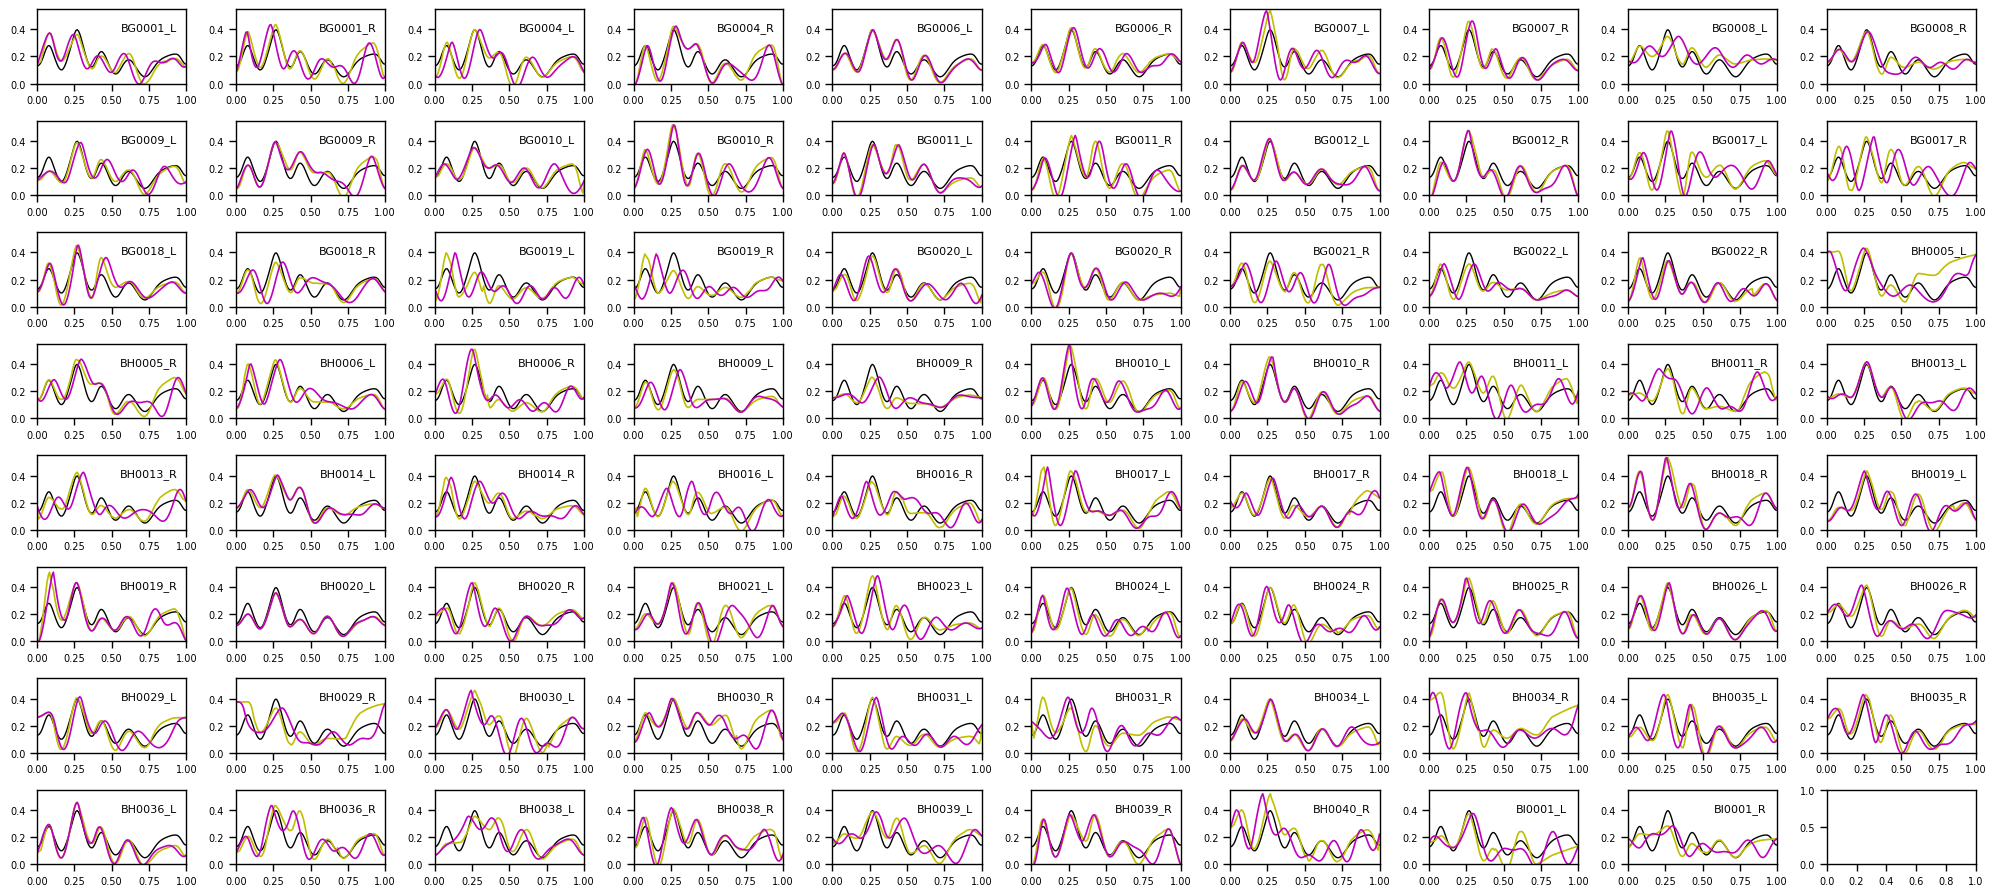

In [8]:
# import matplotlib.pyplot as plt
sns.set_context("paper", font_scale=0.8)
# 创建8x10网格的图形，指定图的尺寸
fig, axes = plt.subplots(8, 10, figsize=(20, 9), dpi=100)

# 遍历所有曲线并在对应的子图中绘制
for udx in range(len(curvatures)):
    # 计算当前子图的行和列索引
    row = udx // 10
    col = udx % 10

    ax = axes[row, col]
    ax.plot(mean_function, alpha=1, linewidth=1, color="k", label='Mean Curve')
    ax.plot(aligned_curvatures[udx], alpha=1, color='y', label='Aligned Curve')
    ax.plot(reparam_curvatures[udx], alpha=1, color='m', label='Original Curve')
    # ax.text(0.9, 0.7, f'{udx+1}', fontsize=12, ha='center', va='center', transform=ax.transAxes)
    ax.text(0.75, 0.75, files_label[udx], fontsize=8, ha='center', va='center', transform=ax.transAxes)
    ax.set_ylim(0, 0.55)
    # ax.set_title(files[udx])
    
    # 可以根据需要启用此行，以设置自定义的 x 轴刻度
    set_x_ticks_normalized(ax, curvatures[0])

    # 隐藏每个子图的图例，以避免图例过多
    # ax.legend()  # 如果需要单独显示图例，可以启用此行

# 调整布局，使子图间距适当
plt.tight_layout()
plt.show()


In [9]:
print (files[51])

brava_cut_mirrored\BH0020_ICA_L.vtk


In [10]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

def find_corresponding_indices(aligned_curvatures, reparam_curvatures, warping_functions, mean_function):
    """
    找到每个 aligned_curvatures[j][peaks[i]] 和 aligned_curvatures[j][troughs[i]]
    在 reparam_curvatures[j] 上的对应索引。
    
    参数:
        aligned_curvatures (numpy.ndarray): 对齐后的曲线数组，形状为 (num_curves, num_points)。
        reparam_curvatures (numpy.ndarray): 原始曲线数组，形状为 (num_curves, num_points)。
        warping_functions (numpy.ndarray): 变形函数数组，形状为 (num_curves, num_points)。
        mean_function (numpy.ndarray): 对齐曲线的均值曲线，用于找到峰值和谷值。
    
    返回:
        dict: 每条曲线的峰值和谷值对应的索引，格式为:
              {j: {'peaks': [list of indices], 'troughs': [list of indices]}}
    """
    # 找到均值曲线的峰值和谷值
    peak_indices, _ = find_peaks(mean_function)
    trough_indices, _ = find_peaks(-mean_function)
    
    # 用于存储结果的字典
    corresponding_indices = {}

    # 遍历每条对齐曲线
    for j in range(len(aligned_curvatures)):
        # 获取当前曲线的变形函数
        warping_func = warping_functions[j]
        x_grid = np.linspace(0, 1, len(warping_func))
        
        # 创建反向插值函数，将 warping_func 映射回 x_grid
        inverse_warp = interp1d(warping_func, x_grid, bounds_error=False, fill_value="extrapolate")
        
        # 找到每个峰值在原始曲线上的对应索引
        peak_indices_reparam = []
        for peak_idx in peak_indices:
            original_x = inverse_warp(x_grid[peak_idx])
            closest_index = (np.abs(x_grid - original_x)).argmin()
            peak_indices_reparam.append(closest_index)
        
        # 找到每个谷值在原始曲线上的对应索引
        trough_indices_reparam = []
        for trough_idx in trough_indices:
            original_x = inverse_warp(x_grid[trough_idx])
            closest_index = (np.abs(x_grid - original_x)).argmin()
            trough_indices_reparam.append(closest_index)
        
        # 存储当前曲线的结果
        corresponding_indices[j] = {
            'peaks': peak_indices_reparam,
            'troughs': trough_indices_reparam
        }
    
    return corresponding_indices


# 调用函数并输出结果
corresponding_indices = find_corresponding_indices(aligned_curvatures, reparam_curvatures, warping_functions, mean_function)
print(corresponding_indices)

# 提取所有曲线的峰值对应索引
peak_indices_reparam = []
trough_indices_reparam = []
for j, indices in corresponding_indices.items():
    peak_indices_reparam.append(indices['peaks'])
    trough_indices_reparam.append(indices['troughs'])

peak_indices_reparam = np.array(peak_indices_reparam)
trough_indices_reparam = np.array(trough_indices_reparam)

indices_reparam = np.concatenate((peak_indices_reparam, trough_indices_reparam), axis=1)
print(indices_reparam.shape)

peaks_troughs = np.array(np.concatenate((peak_indices,trough_indices)), dtype=int)
peak_trough_values = []
for i in range(len(files)):
    # print (aligned_curvatures[i][peaks].shape)
    peak_trough_values.append(aligned_curvatures[i][peaks_troughs])
peak_trough_values = np.array(peak_trough_values)
print (peak_trough_values.shape)


{0: {'peaks': [9, 35, 54, 77, 112], 'troughs': [20, 47, 66, 91]}, 1: {'peaks': [10, 37, 56, 76, 113], 'troughs': [22, 49, 68, 79]}, 2: {'peaks': [5, 28, 49, 69, 109], 'troughs': [15, 41, 60, 82]}, 3: {'peaks': [7, 30, 52, 71, 112], 'troughs': [17, 44, 62, 80]}, 4: {'peaks': [8, 31, 50, 72, 112], 'troughs': [18, 45, 62, 85]}, 5: {'peaks': [7, 30, 48, 69, 105], 'troughs': [17, 42, 60, 84]}, 6: {'peaks': [8, 35, 52, 77, 112], 'troughs': [21, 47, 66, 92]}, 7: {'peaks': [8, 30, 48, 72, 112], 'troughs': [16, 42, 61, 85]}, 8: {'peaks': [3, 24, 41, 54, 92], 'troughs': [11, 35, 48, 64]}, 9: {'peaks': [8, 31, 43, 53, 104], 'troughs': [18, 40, 47, 67]}, 10: {'peaks': [8, 29, 47, 68, 116], 'troughs': [17, 42, 58, 83]}, 11: {'peaks': [9, 32, 50, 76, 112], 'troughs': [19, 45, 61, 80]}, 12: {'peaks': [11, 32, 53, 75, 118], 'troughs': [21, 45, 65, 89]}, 13: {'peaks': [8, 31, 50, 70, 112], 'troughs': [18, 45, 61, 82]}, 14: {'peaks': [9, 31, 49, 73, 114], 'troughs': [18, 45, 61, 85]}, 15: {'peaks': [8, 

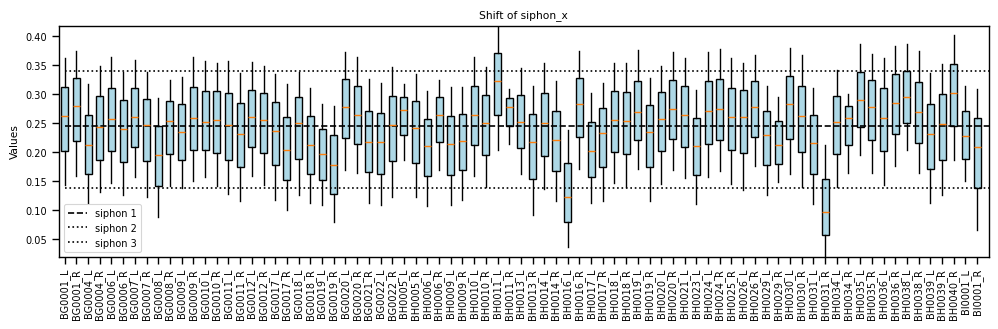

In [11]:
# siphon分布在哪里？

siphon_x_pre = np.stack((indices_reparam[:,5], indices_reparam[:,1], indices_reparam[:,6]), axis=1)

siphon_x = []

for i in range(len(files)):
    center = calculate_curve_length(original_centerlines[i][:siphon_x_pre[i][1]])/calculate_curve_length(original_centerlines[i])
    proximal = calculate_curve_length(original_centerlines[i][:siphon_x_pre[i][-1]])/calculate_curve_length(original_centerlines[i])
    distal = calculate_curve_length(original_centerlines[i][:siphon_x_pre[i][0]])/calculate_curve_length(original_centerlines[i])

    # center_aligned = calculate_curve_length(alig)

    # print (center, proximal, distal)

    siphon_x.append([distal, center, proximal])
siphon_x = np.array(siphon_x)
# print (siphon_x)

# mean_function_siphon = np.array([mean_function[peak_troughs[0]], mean_function[peak_troughs[1]], mean_function[peak_troughs[2]]])



# 为 x 轴生成索引
x = np.arange(siphon_x.shape[0])

# 创建图形并绘制每列的折线图和填充区域
plt.figure(figsize=(12, 3))

# # 绘制三条带面积的折线图
# for i in range(siphon_x.shape[1]):
#     plt.plot(x, siphon_x[:, i], label=f'Line {i + 1}')
#     plt.fill_between(x, siphon_x[:, i], alpha=0.3)  # 填充折线下方区域

plt.boxplot(siphon_x.T, positions=range(len(curve_bs)), widths=0.6, patch_artist=True, showfliers=False, showcaps=False, boxprops=dict(facecolor='lightblue'))

plt.hlines(np.mean(siphon_x[:,1]), 0, siphon_x.shape[0], colors='k', linestyles='--', label='siphon 1')  # 添加零线
plt.hlines(np.mean(siphon_x[:,0]), 0, siphon_x.shape[0], colors='k', linestyles=':', label='siphon 2')  # 添加零线
plt.hlines(np.mean(siphon_x[:,2]), 0, siphon_x.shape[0], colors='k', linestyles=':', label='siphon 3')  # 添加零线



# 设置x轴标签
plt.xticks(ticks=range(len(files)), labels=files_label, rotation=90)  # 将x轴标签设置为files中的字符串


# 添加标签和标题
# plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Shift of siphon_x")
plt.legend()
plt.autoscale(enable=True, axis='x', tight=True)
plt.autoscale(enable=True, axis='y', tight=True)
plt.show()

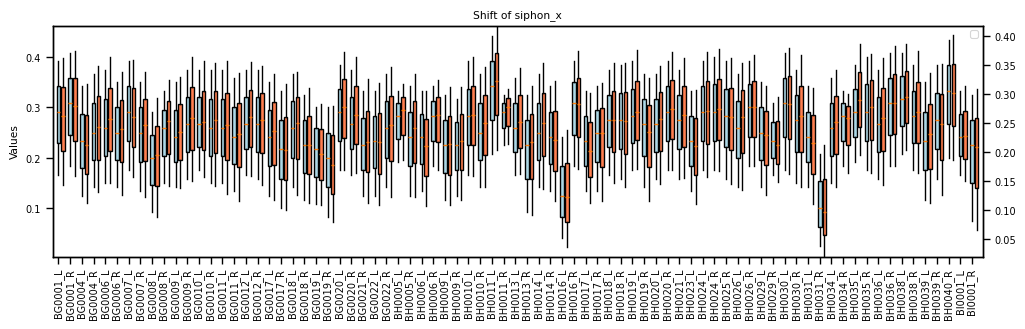

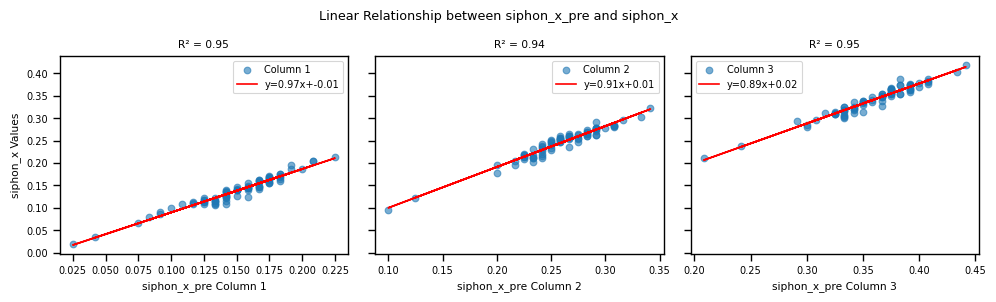

In [12]:
# 用弧长计算siphon位置，和用索引计算siphon位置，有多大差异？
# siphon_x_pre = np.stack((indices_reparam[:,5], indices_reparam[:,1], indices_reparam[:,6]), axis=1)


from scipy.stats import linregress
# 为 x 轴生成索引
x = np.arange(siphon_x_pre.shape[0])

# 创建图形并绘制每列的折线图和填充区域
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(111)
# # 绘制三条带面积的折线图
# for i in range(siphon_x.shape[1]):
#     plt.plot(x, siphon_x[:, i], label=f'Line {i + 1}')
#     plt.fill_between(x, siphon_x[:, i], alpha=0.3)  # 填充折线下方区域

ax.boxplot((siphon_x_pre/len(curvatures[0])).T, positions=np.arange(len(curve_bs)), widths=0.3, patch_artist=True, showfliers=False, showcaps=False, boxprops=dict(facecolor='lightblue'))
ax2 = ax.twinx()
ax2.boxplot(siphon_x.T, positions=np.arange(len(curve_bs))+0.4, widths=0.3, patch_artist=True, showfliers=False, showcaps=False, boxprops=dict(facecolor='coral'))



# 设置x轴标签
ax.set_xticks(ticks=range(len(files)), labels=files_label, rotation=90)  # 将x轴标签设置为files中的字符串


# 添加标签和标题
# plt.xlabel("Index")
ax.set_ylabel("Values")
plt.title("Shift of siphon_x")
plt.legend()
plt.autoscale(enable=True, axis='x', tight=True)
plt.autoscale(enable=True, axis='y', tight=True)
plt.show()

# 初始化图形
fig, axs = plt.subplots(1, siphon_x.shape[1], figsize=(10, 3), sharey=True)
fig.suptitle("Linear Relationship between siphon_x_pre and siphon_x")

for i in range(siphon_x.shape[1]):
    # 获取 siphon_x_pre 和 siphon_x 的对应列
    X = siphon_x_pre[:, i] / len(curvatures[0])  # 归一化处理
    Y = siphon_x[:, i]
    
    # 绘制散点图
    axs[i].scatter(X, Y, label=f'Column {i + 1}', alpha=0.6)
    
    # 线性回归拟合
    slope, intercept, r_value, p_value, std_err = linregress(X, Y)
    axs[i].plot(X, slope * X + intercept, color="red", label=f'y={slope:.2f}x+{intercept:.2f}')
    
    # 显示相关信息
    axs[i].set_xlabel(f'siphon_x_pre Column {i + 1}')
    axs[i].set_title(f'R² = {r_value**2:.2f}')
    axs[i].legend()

axs[0].set_ylabel("siphon_x Values")
plt.tight_layout()
plt.show()

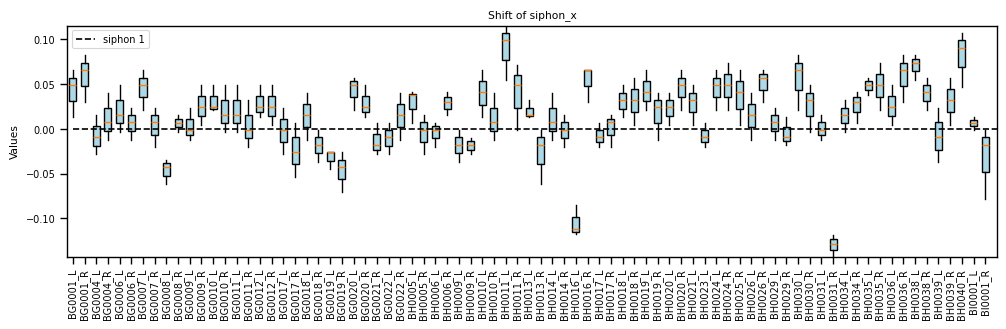

(3, 79)


In [13]:
# 创建图形并绘制每列的折线图和填充区域
plt.figure(figsize=(12, 3))


siphon_on_mean_function = ([peaks_troughs[5], peaks_troughs[1], peaks_troughs[6]])*np.array([0.97,0.91,0.89])
# print (siphon_on_mean_function)
# print (siphon_x_pre)
plt.boxplot(((siphon_x_pre-siphon_on_mean_function).T)/len(mean_function), positions=range(len(curve_bs)), widths=0.6, patch_artist=True, showfliers=False, showcaps=False, boxprops=dict(facecolor='lightblue'))

plt.hlines(0, 0, siphon_x.shape[0], colors='k', linestyles='--', label='siphon 1')  # 添加零线

# 设置x轴标签
plt.xticks(ticks=range(len(files)), labels=files_label, rotation=90)  # 将x轴标签设置为files中的字符串


# 添加标签和标题
# plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Shift of siphon_x")
plt.legend()
plt.autoscale(enable=True, axis='x', tight=True)
plt.autoscale(enable=True, axis='y', tight=True)
plt.show()

print ((((siphon_x_pre-siphon_on_mean_function).T)/len(mean_function)).shape)


(3, 79)


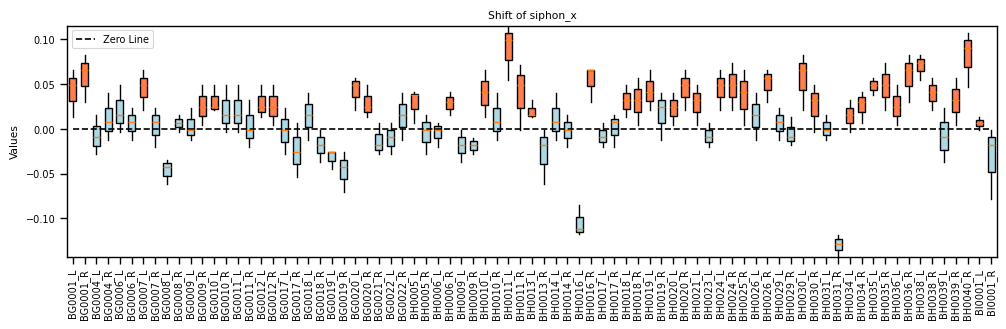

(79,)


In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 创建图形
plt.figure(figsize=(12, 3))

# 计算并调整数据
adjusted_data = ((siphon_x_pre - siphon_on_mean_function) / len(mean_function)).T


print (adjusted_data.shape)

Shift = []
# 绘制每列的 boxplot，根据均值设置不同颜色
for i in range(adjusted_data.shape[1]):
    column_data = adjusted_data[:, i]
    mean_value = np.mean(column_data)-np.std(column_data)
    color = 'coral' if mean_value > 0 else 'lightblue'
    
    # 绘制 boxplot
    plt.boxplot(column_data, positions=[i], widths=0.6, patch_artist=True, 
                showfliers=False, showcaps=False, boxprops=dict(facecolor=color))
    Shift.append(mean_value)

# 添加零线
plt.hlines(0, 0, adjusted_data.shape[1] - 1, colors='k', linestyles='--', label='Zero Line')

# 设置x轴标签
plt.xticks(ticks=range(len(files)), labels=files_label, rotation=90)

# 添加标签和标题
plt.ylabel("Values")
plt.title("Shift of siphon_x")
plt.legend()
plt.autoscale(enable=True, axis='x', tight=True)
plt.autoscale(enable=True, axis='y', tight=True)
plt.show()
Shift = np.array(Shift)

print (Shift.shape)

(5,)


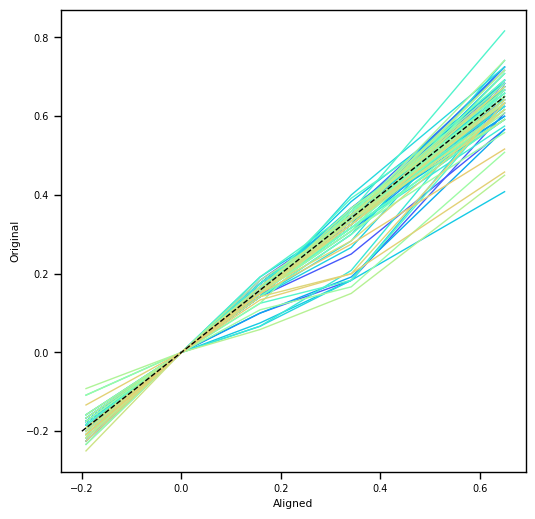

In [15]:
# 其他landmark相对于siphon的移动情况

# mean_function_diff = peaks_troughs - peaks_troughs[1] # 对齐后的各点与siphon的差值
mean_function_diff = peak_indices - peak_indices[1] # 对齐后的各点与siphon的差值
curvature_diffs = []
for i in range(len(files)):
    # curvature_diffs.append(indices_reparam[i] - indices_reparam[i][1]) # 对齐前的各点与siphon的差值
    curvature_diffs.append(peak_indices_reparam[i]-peak_indices_reparam[i][1]) # 对齐前的各点与siphon的差值
curvature_diffs = np.array(curvature_diffs)
# print (mean_function_diff)
# print (curvature_diffs)
# diff_indices = ((curvature_diffs-mean_function_diff)/len(mean_function)) # 如果为负，意味着需要收缩才能对齐，则原先的曲线是舒张的
diff_indices = ((curvature_diffs)/len(mean_function)) 
print (diff_indices[0].shape)
mean_diff_indices = (mean_function_diff/len(mean_function))


# # print (diff_indices)
colors = cm.rainbow(np.linspace(0.05, 0.70, num_curves))
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)


for i in range(79):
    ax.plot(mean_diff_indices, diff_indices[i], alpha=1, linewidth=1, color=colors[i])
# for j in [0,2,3,4]:
#     for i in range(len(diff_indices)):
#         ax.scatter(i, diff_indices[i][j]/Shift[i], marker='${}$'.format(j+1), color=colors[i])

# ax.hlines(0, 0, siphon_x.shape[0], colors='k', linestyles='--', label='siphon 1')  # 添加零线
# plt.hlines(-1, 0, siphon_x.shape[0], colors='k', linestyles=':', label='siphon 0')  # 添加零线
# plt.hlines(1, 0, siphon_x.shape[0], colors='k', linestyles=':', label='siphon 2')  # 添加零线
# ax.set_xticks(ticks=range(len(files)), labels=files_label, rotation=90)  # 将x轴标签设置为files中的字符串
ax.set_ylabel("Original")
ax.set_xlabel("Aligned")
# ax.set_title("Area Plots for Each Column of siphon_x")
# ax.set_ylim([-5,5])

ax.plot([-0.2,0.65],[-0.2,0.65], color='k', linestyle='--', linewidth=1)
# ax.autoscale(enable=True, axis='x', tight=True)
# ax.autoscale(enable=True, axis='y', tight=True)


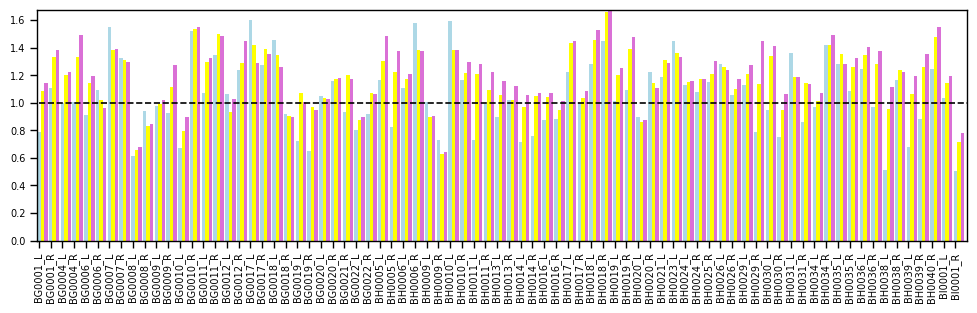

In [16]:
# siphon相对mean function中的siphon的intensity变化情况，对比landmark和mean function中的landmark的intensity变化情况，对比整体的intensity变化情况

siphon_curvature = (aligned_curvatures[:, peak_indices[1]] - (aligned_curvatures[:, trough_indices[0]]+aligned_curvatures[:, trough_indices[1]])/2)/(mean_function[peak_indices[1]]-(mean_function[trough_indices[0]]+mean_function[trough_indices[1]])/2)
plt.figure(figsize=(12, 3))


landmark_std = np.std(aligned_curvatures[:,peaks_troughs],axis=1)
mean_landmark_std = np.std(mean_function[peaks_troughs])
landmark_average = landmark_std/mean_landmark_std

total_std = np.std(aligned_curvatures,axis=1)
mean_total_std = np.std(mean_function)
total_average = total_std/mean_total_std


# 第一个柱状图
plt.bar(np.arange(len(siphon_curvature)), siphon_curvature, width=0.3, color='lightblue', label="Siphon Curvature")

# 第二个柱状图，x 位置偏移 0.4
plt.bar(np.arange(len(landmark_average)) + 0.3, landmark_average, width=0.3, color='yellow', label="Landmark Average")
plt.bar(np.arange(len(total_average)) + 0.6, total_average, width=0.3, color='orchid', label="Total Average")

plt.hlines(1, 0, len(siphon_curvature), colors='k', linestyles='--', label='Zero')  
# 设置x轴标签
plt.xticks(ticks=range(len(files)), labels=files_label, rotation=90)  # 将x轴标签设置为files中的字符串
plt.autoscale(enable=True, axis='x', tight=True)
plt.autoscale(enable=True, axis='y', tight=True)
plt.show()

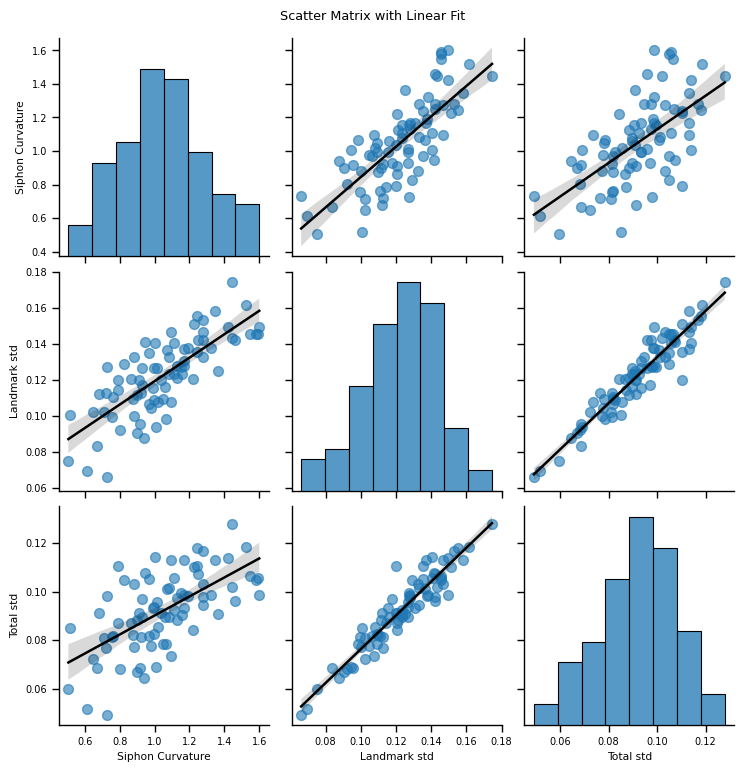

In [17]:
import pandas as pd

# 创建数据框，将数据转为 Pandas 格式便于 Seaborn 处理
data = pd.DataFrame({
    'Siphon Curvature': siphon_curvature,
    'Landmark std': landmark_std,
    'Total std': total_std
})

# print (data)
# 使用 seaborn 绘制带有拟合曲线的散点图矩阵
sns.pairplot(data, kind='reg', plot_kws={'line_kws':{'color':'k'}, 'scatter_kws': {'alpha': 0.6, 's': 50}})

# 添加标题
plt.suptitle("Scatter Matrix with Linear Fit", y=1.02)
plt.show()

# 结果说明这些landmark上的intensity很有代表性（？）

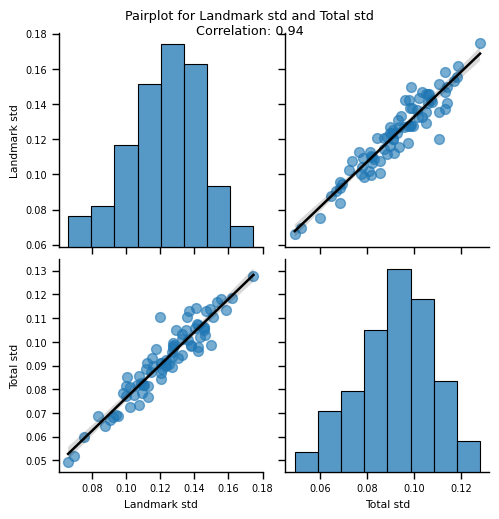

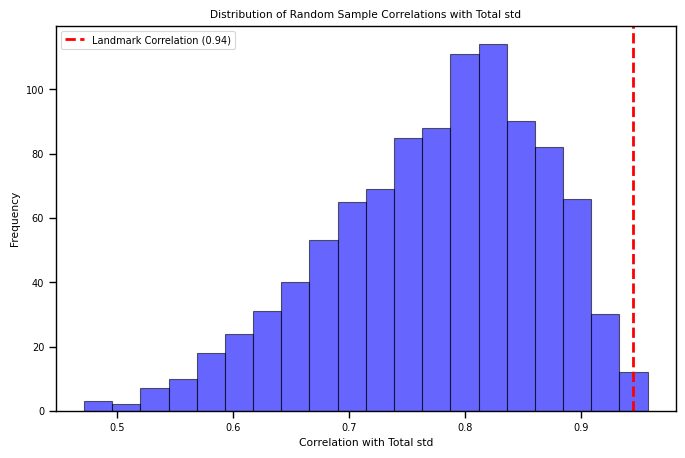

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 计算 landmark_std 和 total_std
landmark_std = np.std(aligned_curvatures[:, peaks_troughs], axis=1)
total_std = np.std(aligned_curvatures, axis=1)

# 创建 DataFrame 保存 Siphon Curvature, Landmark std, Total std
data = pd.DataFrame({
    'Siphon Curvature': siphon_curvature,
    'Landmark std': landmark_std,
    'Total std': total_std
})

# 计算 landmark_std 和 total_std 之间的相关系数
landmark_total_corr = np.corrcoef(landmark_std, total_std)[0, 1]

# 随机选择10个点多次，并计算它们的标准差和 total_std 的相关性
random_corrs = []
num_random_samples = 1000  # 设置随机采样次数
num_random_points = 10    # 每次选择10个随机点

for _ in range(num_random_samples):
    random_points = np.random.choice(aligned_curvatures.shape[1], num_random_points, replace=False)
    random_std = np.std(aligned_curvatures[:, random_points], axis=1)
    random_corr = np.corrcoef(random_std, total_std)[0, 1]
    random_corrs.append(random_corr)

# 转换为 DataFrame 以便于绘制和比较
random_corrs_df = pd.DataFrame({
    'Random Sample Correlation': random_corrs
})

# 绘制 landmark_std 和 total_std 的配对图，并显示相关系数
sns.pairplot(data[['Landmark std', 'Total std']], kind='reg', plot_kws={'line_kws': {'color': 'k'}, 'scatter_kws': {'alpha': 0.6, 's': 50}})
plt.suptitle(f"Pairplot for Landmark std and Total std\nCorrelation: {landmark_total_corr:.2f}", y=1.02)
plt.show()

# 绘制随机样本相关性直方图，添加 landmark_std 和 total_std 相关性的垂直线
plt.figure(figsize=(8, 5))
plt.hist(random_corrs, bins=20, alpha=0.6, color='b', edgecolor='k')
plt.axvline(x=landmark_total_corr, color='r', linestyle='--', linewidth=2, label=f'Landmark Correlation ({landmark_total_corr:.2f})')
plt.xlabel("Correlation with Total std")
plt.ylabel("Frequency")
plt.title("Distribution of Random Sample Correlations with Total std")
plt.legend()
plt.show()


(5, 79)


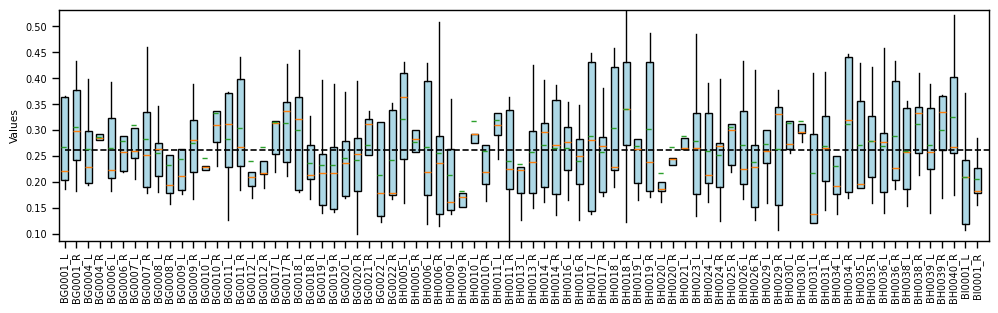

In [19]:
plt.figure(figsize=(12, 3))

# # 绘制三条带面积的折线图
# for i in range(siphon_x.shape[1]):
#     plt.plot(x, siphon_x[:, i], label=f'Line {i + 1}')
#     plt.fill_between(x, siphon_x[:, i], alpha=0.3)  # 填充折线下方区域
# print (peaks_troughs)
# a = aligned_curvatures[:,peaks_troughs].T
a = aligned_curvatures[:,peak_indices].T
print (a.shape)
plt.boxplot(a, positions=range(len(curve_bs)), widths=0.6, patch_artist=True, showfliers=False, showcaps=False, boxprops=dict(facecolor='lightblue'),showmeans=True, meanline=True)

# plt.hlines(np.mean(mean_function[peaks_troughs]), 0, siphon_x.shape[0], colors='k', linestyles='--', label='siphon 1')  # 添加零线
plt.hlines(np.mean(mean_function[peak_indices]), 0, siphon_x.shape[0], colors='k', linestyles='--', label='siphon 1')  # 添加零线
# plt.hlines(trough_indices[0], 0, siphon_x.shape[0], colors='k', linestyles=':', label='siphon 0')  # 添加零线
# plt.hlines(trough_indices[1], 0, siphon_x.shape[0], colors='k', linestyles=':', label='siphon 2')  # 添加零线


# 添加标签和标题
# 设置x轴标签
plt.xticks(ticks=range(len(files)), labels=files_label, rotation=90)  # 将x轴标签设置为files中的字符串
plt.ylabel("Values")
# plt.title("Area Plots for Each Column of siphon_x")
# plt.legend()
plt.autoscale(enable=True, axis='x', tight=True)
plt.autoscale(enable=True, axis='y', tight=True)
plt.show()